<a href="https://colab.research.google.com/github/Hakimvira/mlProject/blob/master/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Default

In [1]:
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

     |████████████████████████████████| 719 kB 5.4 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
     |████████████████████████████████| 432 kB 40.8 MB/s 
     |████████████████████████████████| 4.9 MB 47.6 MB/s 
     |████████████████████████████████| 1.3 MB 48.5 MB/s 
     |████████████████████████████████| 212 kB 53.4 MB/s 
     |████████████████████████████████| 163 kB 56.2 MB/s 
     |████████████████████████████████| 115 kB 52.4 MB/s 
     |████████████████████████████████| 127 kB 47.9 MB/s 
     |████████████████████████████████| 6.6 MB 43.0 MB/s 


Download Datasets from kaggle

In [2]:
creds = '{"username":"hakimvira","key":"73c7f0cfe380fbebe0fa74ad1b3e781f"}'

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [3]:
comp = 'titanic'
path = URLs.path(comp)
Path.BASE_PATH = path

In [4]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

100%|██████████| 34.1k/34.1k [00:00<00:00, 18.0MB/s]

(#3) [Path('test.csv'),Path('train.csv'),Path('gender_submission.csv')]

View data

In [5]:
df = pd.read_csv(path/'train.csv')

In [7]:
df.head()

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",...,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",...,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",...,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",...,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",...,373450,8.0500,NaN,S


Clean the data

In [8]:
toDrop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
filterDf = df.drop(columns=toDrop)
filterDf.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [14]:
dep_var = 'Survived'
catCol = ['Pclass', 'Sex', 'Embarked']
contCol = ['Age', 'SibSp', 'Parch', 'Fare']

In [30]:
procs = [Categorify, FillMissing, Normalize]

In [31]:
splits = RandomSplitter(valid_pct=0.2)(range_of(filterDf))
to = TabularPandas(filterDf,
                   procs = procs,
                   splits = splits,
                   cat_names = catCol,
                   cont_names = contCol,
                   y_names=dep_var)

In [32]:
to.show(3)

,Pclass,Sex,Embarked,Age_na,Age,SibSp,Parch,Fare,Survived
322,2,female,Q,False,30.0,0.0,0.0,12.350,1
147,3,female,S,False,9.0,2.0,2.0,34.375,0
861,2,male,S,False,21.0,1.0,0.0,11.500,0


In [33]:
xs , y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

Training - Decision Tree

In [34]:
m = DecisionTreeRegressor(max_leaf_nodes = 4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

Check Accuracy

In [35]:
def r_mse(pred,y): 
  return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y): 
  return r_mse(m.predict(xs), y)

In [37]:
m_rmse(m, valid_xs, valid_y)

0.376539

Training - Random Forest

In [41]:
def rf(xs, y, n_estimators=40, max_samples=100,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [48]:
m = rf(xs, y,  max_samples=700);

In [49]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)


(0.30177, 0.357661)

Feature Importance

In [50]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [51]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
1,Sex,0.425596
7,Fare,0.193669
4,Age,0.161386
0,Pclass,0.110384
5,SibSp,0.056732
6,Parch,0.021320
2,Embarked,0.020651
3,Age_na,0.010263


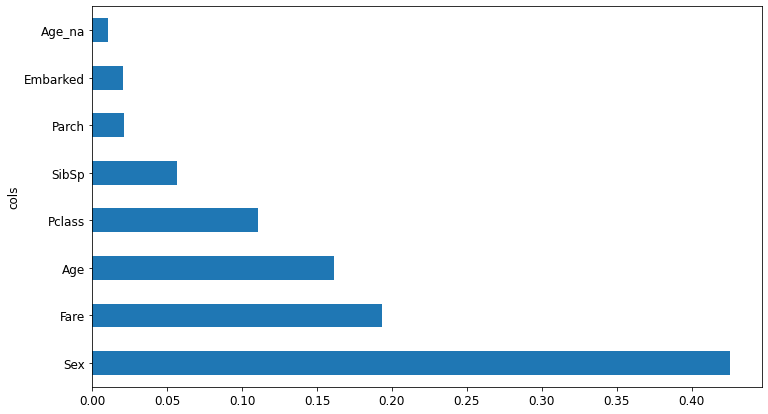

In [52]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Training Neural Network

In [88]:
filterDf['Survived'] = filterDf['Survived'].astype(np.float32)

In [89]:
cont_nn,cat_nn = cont_cat_split(filterDf, max_card=9000, dep_var=dep_var)
cont_nn, cat_nn

(['Age', 'Fare'], ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'])

In [90]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(filterDf, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [91]:
dls = to_nn.dataloaders(500)

In [92]:
learn = tabular_learner(dls, y_range=(0.0,1.0), layers=[200,100],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0014454397605732083)

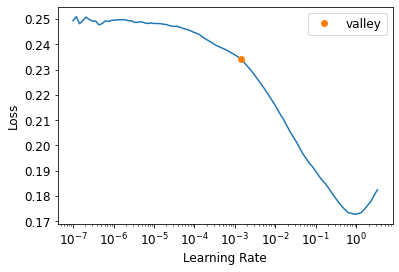

In [94]:
learn.lr_find()

In [95]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.248147,0.246348,00:00
1,0.241382,0.241127,00:00
2,0.256222,0.233856,00:00
3,0.248368,0.228249,00:00
4,0.242051,0.226030,00:00


In [96]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.475427